# User Onboarding chat

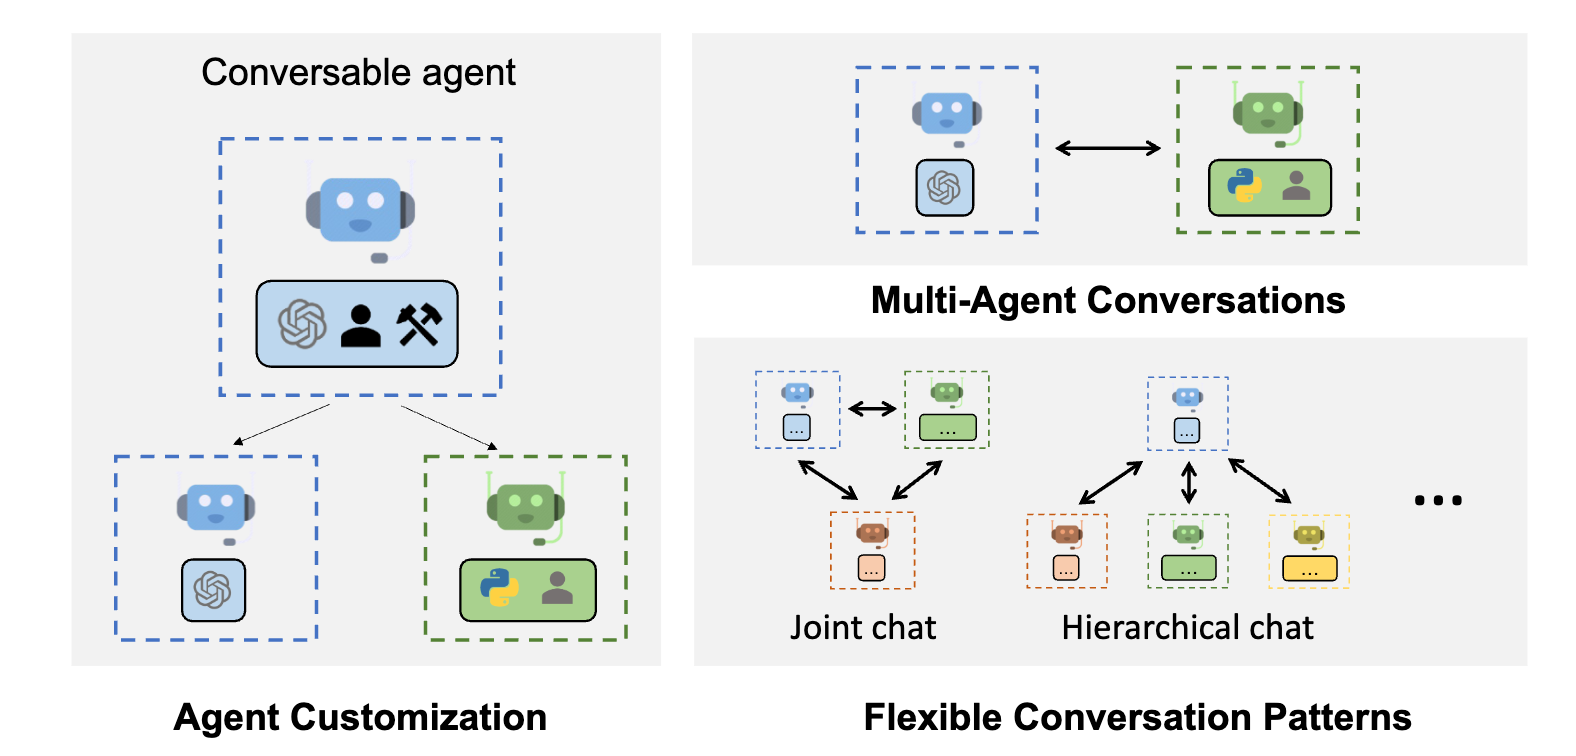

In this project, agents are used to gather specifc information about a user that needs help, then pass that information to human that will directly have a clear understanding of who requires help, where they're from and what their problem is, so that the human can immediately act on this information and help the user.

3 agents are created for this purpose:
1. An **Onboarding Personal Information Agent**: this agent's goal is to get the name and location of the customer.
2. An **Onboarding Issue Agent**: this agent's goal is to determine what the issue of the customer is.
3. A  **Customer Engagement Agent**: this agent will interact with the customer until a human agent can start interacting with the customer.

To make things simpler, we will assume that these agents are deployed by a phone provider company called "AIRTEL".

In [2]:
# llm_config object to configure agents
llm_config = {
    "model": "gpt-4o-mini", 
    "api_key": "sk-proj-"
    }

## Agents definition

We will first define the agents:

In [3]:
from autogen import ConversableAgent

The first agent is **Onboarding Personal Information Agent**. Its main goal is to get the name and location of the customer. 

In [4]:
onboarding_personal_information_agent = ConversableAgent(
    name="Onboarding_Personal_Information_Agent",
    system_message='''You are a helpful customer onboarding agent,
    you work for a phone provider called AIRTEL.
    Your job is to gather the customer's name and location.
    Do not ask for any other information, only ask about the customer's name and location.
    After the customer gives you their name and location, repeat them 
    and thank the user, and ask the user to answer with TERMINATE to move on to describing their issue.
    ''',
    llm_config=llm_config,
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: "terminate" in msg.get("content").lower()
)

The second agent is **Onboarding Issue Agent**. Its main goal is to determine the issue the customer is facing with the products.

In [5]:
onboarding_issue_agent = ConversableAgent(
    name="Onboarding_Issue_Agent",
    system_message='''You are a helpful customer onboarding agent,
    you work for a phone provider called AIRTEL,
    you are here to help new customers get started with our product.
    Your job is to gather the product the customer use and the issue they currently 
    have with the product,
    Do not ask for other information.
    After the customer describes their issue, repeat it and add
    "Please answer with 'TERMINATE' if I have correctly understood your issue." ''',
    llm_config=llm_config,
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: "terminate" in msg.get("content").lower()
)

The third agent is **Customer Engagement Agent**. Its main goal is to interact with the customer based on the previously gathered information until a human agent can start intertacting with the customer to solve their issue.

In [6]:
customer_engagement_agent = ConversableAgent(
    name="Customer_Engagement_Agent",
    system_message='''You are a helpful customer service agent.
    Your job is to gather customer's preferences on news topics.
    You are here to provide fun and useful information to the customer based on the user's
    personal information and topic preferences.
    This could include fun facts, jokes, or interesting stories.
    Make sure to make it engaging and fun!
    Return 'TERMINATE' when you are done.''',
    llm_config=llm_config,
    human_input_mode="NEVER",
    is_termination_msg=lambda msg: "terminate" in msg.get("content").lower(),
)

We will also have to define a **customer proxy agent**. The customer proxy agent is a Conversable Agent that is not an LLM (`llm_config=False`), it will however have the `human_input_mode="ALWAYS"` which means that you, the human, will play the role of this agent. You will be the customer through this agent.

In [7]:
customer_proxy_agent = ConversableAgent(
    name="customer_proxy_agent",
    llm_config=False,
    code_execution_config=False,
    human_input_mode="ALWAYS",
)

Next step is now to orchestrate the chat

## Chat orchestration

Now we will define in which order agents will interact and who'll interact with who when. To define this, we will use a list, that will contain several elements, each one corresponding to a chat. The chats will then happen in that specific order.

Let's define a `chat` object and then the first chat:

In [8]:
chats = [] # This is going to be list of chats

### 1. Onboarding Agent with Customer

The first chat will be between first agent, the **Onboarding Personal Information Agent** and the **customer**.

The first message will be sent by the **Onboarding Personal Information Agent** and will be:
> *Hello, I'm here to help you get started with our product. 
            Could you tell me your name?*

#### Carrying data to the next chat

In order to make the transition easier with the next agent, We are going to request a summary generated by the LLM, but **we will specify that the summary should return the name and location of the customer in a JSON format:** `{'name': '', 'location': ''}`. This is a structured data format that can be easily read by another agent but **also by another app or protocol**. This shows how an LLM agent can be used to interact with other apps.

Since we only want to transfer name and location to the next chat and we specifically specified how we want to transfer this data, we are going to add a new parameter, the `clear_history` to `True` which means that no data other than the one specified in the summary will be sent to the next chat. If we set it to `False` the agent from the next chat will be aware about the previous exchange with the user. 

In [9]:
chats.append(
    {
        "sender": onboarding_personal_information_agent,
        "recipient": customer_proxy_agent,
        "message": 
            "Hello, I'm here to help you solve any issue you have with our products. "
            "Could you tell me your name?",
        "summary_method": "reflection_with_llm",
        "summary_args": {
        "summary_prompt" : "Return the customer information "
                             "into a JSON object only: "
                             "{'name': '', 'location': ''}",
        },
        "clear_history" : True
    }
)

### 2. Issue Agent with Customer

We will now define the second chat and add it to this list. The second chat will be between the second agent, the **Issue Agent** and the **customer**.

The second message will be sent by the **Onboarding Personal Information Agent** and will be:
> *Great! Could you tell me what issue you're currently having and with which product?*

This time we're going to generate a summary, but we won't specify any format or specifc fata that must be carried over because we do not know what the exchange will yield specifically. We are also going to specify that we want to transfer the chat history to the next chat/agent.

In [10]:
chats.append(
    {
        "sender": onboarding_issue_agent,
        "recipient": customer_proxy_agent,
        "message": 
                "Great! Could you tell me what issue you're "
                "currently having and with which product?",
        "summary_method": "reflection_with_llm",
        "clear_history" : False
    }
)

### 3. Customer Engagement Agent with Customer

We will now define the third chat and add it to this list. The third chat will be between third agent, the **Customer Engagement Agent** and the **customer**, who is going to be us again.

The third message will be sent by the **Customer Engagement Agent** and will be:
> *Can you tell me more about how you use our products or some topics interesting for you?*

This time we're going to generate a summary so that the human agent can get this information in an easy and quick way when they take over the conversation, but we won't specify any format or specifc fata that must be carried over because we do not know what the exchange will yield specifically. 

In [11]:
chats.append(
        {
        "sender": customer_proxy_agent,
        "recipient": customer_engagement_agent,
        "message": "While we're waiting for a human agent to take over and help you solve "
        "your issue, can you tell me more about how you use our products or some "
        "topics interesting for you?",
        "max_turns": 2,
        "summary_method": "reflection_with_llm",
    }
)
chats

[{'sender': <autogen.agentchat.conversable_agent.ConversableAgent at 0x10e2e7b90>,
  'recipient': <autogen.agentchat.conversable_agent.ConversableAgent at 0x112e54da0>,
  'message': "Hello, I'm here to help you solve any issue you have with our products. Could you tell me your name?",
  'summary_method': 'reflection_with_llm',
  'summary_args': {'summary_prompt': "Return the customer information into a JSON object only: {'name': '', 'location': ''}"},
  'clear_history': True},
 {'sender': <autogen.agentchat.conversable_agent.ConversableAgent at 0x10e8cd1c0>,
  'recipient': <autogen.agentchat.conversable_agent.ConversableAgent at 0x112e54da0>,
  'message': "Great! Could you tell me what issue you're currently having and with which product?",
  'summary_method': 'reflection_with_llm',
  'clear_history': False},
 {'sender': <autogen.agentchat.conversable_agent.ConversableAgent at 0x112e54da0>,
  'recipient': <autogen.agentchat.conversable_agent.ConversableAgent at 0x112e36210>,
  'message

## Initiate the sequential chat

Now that we finished orchestrating the chat, we can get it started!  
For this to work, **you**, the customer, will have to roleplay as a customer that currently have an issue with your phone provider. Let's say that your internet does not work, or that you want more bandwidth, or that you want some help to setup port forwarding to play a game with some friends or some other thing.

In [12]:
from autogen import initiate_chats

chat_results = initiate_chats(chats)


********************************************************************************
Starting a new chat....

********************************************************************************
Onboarding_Personal_Information_Agent (to customer_proxy_agent):

Hello, I'm here to help you solve any issue you have with our products. Could you tell me your name?

--------------------------------------------------------------------------------


/Users/raghu/GenAI_Projects/autogen_workspace/.venv/lib/python3.12/site-packages/autogen/agentchat/chat.py:57: UserWarning: Repetitive recipients detected: The chat history will be cleared by default if a recipient appears more than once. To retain the chat history, please set 'clear_history=False' in the configuration of the repeating agent.
  warnings.warn(


Replying as customer_proxy_agent. Provide feedback to Onboarding_Personal_Information_Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  Raghu


customer_proxy_agent (to Onboarding_Personal_Information_Agent):

Raghu

--------------------------------------------------------------------------------
Onboarding_Personal_Information_Agent (to customer_proxy_agent):

Thank you, Raghu! Could you please share your location next?

--------------------------------------------------------------------------------


Replying as customer_proxy_agent. Provide feedback to Onboarding_Personal_Information_Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  Bangalore


customer_proxy_agent (to Onboarding_Personal_Information_Agent):

Bangalore

--------------------------------------------------------------------------------
Onboarding_Personal_Information_Agent (to customer_proxy_agent):

Thank you, Raghu from Bangalore! Please respond with "TERMINATE" to move on to describing your issue.

--------------------------------------------------------------------------------


Replying as customer_proxy_agent. Provide feedback to Onboarding_Personal_Information_Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  TERMINATE


customer_proxy_agent (to Onboarding_Personal_Information_Agent):

TERMINATE

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (233249c9-6401-4837-b98e-5fbba2923c8c): Termination message condition on agent 'Onboarding_Personal_Information_Agent' met

********************************************************************************
Starting a new chat....

********************************************************************************
Onboarding_Issue_Agent (to customer_proxy_agent):

Great! Could you tell me what issue you're currently having and with which product?
Context: 
```json
{
  "name": "Raghu",
  "location": "Bangalore"
}
```

--------------------------------------------------------------------------------


Replying as customer_proxy_agent. Provide feedback to Onboarding_Issue_Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  SIM not working


customer_proxy_agent (to Onboarding_Issue_Agent):

SIM not working

--------------------------------------------------------------------------------
Onboarding_Issue_Agent (to customer_proxy_agent):

So, you're experiencing an issue where your SIM is not working. Please answer with 'TERMINATE' if I have correctly understood your issue.

--------------------------------------------------------------------------------


Replying as customer_proxy_agent. Provide feedback to Onboarding_Issue_Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  TERMINATE


customer_proxy_agent (to Onboarding_Issue_Agent):

TERMINATE

--------------------------------------------------------------------------------

>>>>>>>> TERMINATING RUN (83f5d235-6e2e-490a-a576-0ff3825da73d): Termination message condition on agent 'Onboarding_Issue_Agent' met

********************************************************************************
Starting a new chat....

********************************************************************************
customer_proxy_agent (to Customer_Engagement_Agent):

While we're waiting for a human agent to take over and help you solve your issue, can you tell me more about how you use our products or some topics interesting for you?
Context: 
```json
{
  "name": "Raghu",
  "location": "Bangalore"
}
```
The user, Raghu from Bangalore, is experiencing an issue with a non-working SIM.

--------------------------------------------------------------------------------
Customer_Engagement_Agent (to customer_proxy_agent):

Hi Raghu! While we wait

Replying as customer_proxy_agent. Provide feedback to Customer_Engagement_Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  



>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
customer_proxy_agent (to Customer_Engagement_Agent):



--------------------------------------------------------------------------------
Customer_Engagement_Agent (to customer_proxy_agent):

It looks like we're still waiting for your human agent, Raghu! But that just means more time for fun!

Since you're interested in technology, have you seen how Bangalore is becoming a hotspot for AI and machine learning startups? It’s pretty fascinating! For instance, companies here are using AI to solve real-world problems ranging from healthcare to environmental sustainability. Talk about innovation!

Here’s another fun fact: Bangalore has the highest number of tech startups in India, which is even more than Silicon Valley in the early 2000s! If you're interested in specific tech innovations or local tech events, I can share some details.

Oh, and if you’re a fan of food, I can’t help but mention that Bangalore is famous for its div

Provide feedback to Onboarding Personal Information Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  Montreal, Canada


customer_proxy_agent (to Onboarding Personal Information Agent):

Montreal, Canada

--------------------------------------------------------------------------------
Onboarding Personal Information Agent (to customer_proxy_agent):

Great, thank you for sharing, Ilyass. You are located in Montreal, Canada. Now, could you please type TERMINATE to proceed with describing your issue?

--------------------------------------------------------------------------------


Provide feedback to Onboarding Personal Information Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  TERMINATE


customer_proxy_agent (to Onboarding Personal Information Agent):

TERMINATE

--------------------------------------------------------------------------------

********************************************************************************
Starting a new chat....

********************************************************************************
Onboarding Issue Agent (to customer_proxy_agent):

Great! Could you tell me what issue you're currently having and with which product?
Context: 
{
  "name": "Ilyass",
  "location": "Montreal, Canada"
}

--------------------------------------------------------------------------------


Provide feedback to Onboarding Issue Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  I'm having 5G connectivity issues with my S23 Ultra


customer_proxy_agent (to Onboarding Issue Agent):

I'm having 5G connectivity issues with my S23 Ultra

--------------------------------------------------------------------------------
Onboarding Issue Agent (to customer_proxy_agent):

I understand that you're experiencing 5G connectivity issues with your S23 Ultra. 
Please answer with 'TERMINATE' if I have correctly understood your issue.

--------------------------------------------------------------------------------


Provide feedback to Onboarding Issue Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  TERMINATE


customer_proxy_agent (to Onboarding Issue Agent):

TERMINATE

--------------------------------------------------------------------------------

********************************************************************************
Starting a new chat....

********************************************************************************
customer_proxy_agent (to Customer Engagement Agent):

While we're waiting for a human agent to take over and help you solve your issue, can you tell me more about how you use our products or some topics interesting for you?
Context: 
{
  "name": "Ilyass",
  "location": "Montreal, Canada"
}
The user is experiencing 5G connectivity issues with their S23 Ultra.

--------------------------------------------------------------------------------
Customer Engagement Agent (to customer_proxy_agent):

Hey Ilyass! While we wait for a human agent to assist with your 5G connectivity issues, let's chat about some interesting news topics that you might enjoy.

Since you're in

Provide feedback to Customer Engagement Agent. Press enter to skip and use auto-reply, or type 'exit' to end the conversation:  When do you think I'll be able to run LLM agents on my S23 Ultra smartphone?


customer_proxy_agent (to Customer Engagement Agent):

When do you think I'll be able to run LLM agents on my S23 Ultra smartphone?

--------------------------------------------------------------------------------
Customer Engagement Agent (to customer_proxy_agent):

Running Large Language Models (LLM) agents like GPT-3 on smartphones is an exciting prospect for the future of mobile technology. While current smartphones may not have the processing power to run these models efficiently, advancements in mobile hardware and software are constantly being made.

With the rapid progress in technology, it's possible that in the near future, smartphones like the S23 Ultra could have the capability to run LLM agents smoothly. Companies are always working on optimizing performance and efficiency to meet the demands of users like you who are interested in leveraging powerful language models on their mobile devices.

It's an exciting time to be in the tech world, and who knows, you might be running

And that's all for the exchange! It could go on for longer, but remember that we specified a `max_turns` settings for each chat, there is no need to let this last for too long since we're just running examples.

Now once the human agent is ready to take over the conversation, we can provide them with a summary of all the information necessary so that they can immediately get started with solving the issue of the customer using the following commads, as we previously explored:

In [13]:
import pprint

for chat_result in chat_results:
    #pprint.pprint(chat_result.chat_history) # We could also get the whole chat history with this command
    pprint.pprint(chat_result.summary)

'```json\n{\n  "name": "Raghu",\n  "location": "Bangalore"\n}\n```'
('The user, Raghu from Bangalore, is experiencing an issue with a non-working '
 'SIM.')
('Raghu from Bangalore is experiencing an issue with a non-working SIM. While '
 "waiting for a human agent, the conversation highlighted Bangalore's status "
 'as a tech hub, specifically in AI and machine learning, and shared fun facts '
 'and light-hearted jokes related to technology. The agent also offered to '
 "discuss local cuisine and events, showing interest in Raghu's preferences.")


The human can thus quickly learn about our customer, their name, location and issue and immediately get started on solving the issue.